In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from rbm.definitions import DATASET_DIR, MODEL_DIR
from rbm.tmc_utils import loadTMCsave, plot_valsing_evol, loadTMCRBM
from rbm.functions import ComputeProbabilityTMC1D

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float

# The name of the file to analyze. It can either be the AllParameters (indexed on the number of update) or the RBM one.
# The file should be located in MODEL_DIR 
model_name = 'RBMDemo1d2cB.h5'


# Load dataset and model

In [2]:
data = torch.tensor(np.genfromtxt(DATASET_DIR.joinpath('data_1d_2c_balanced.dat')).T, dtype=dtype, device=device)
# The data is binary with values in {-1, 1}, so we scale it to be in {0, 1}
data = (data+1)/2

_, _, V = torch.svd(data.T)
proj_data = torch.mm(data.T, V).cpu()/data.shape[0]**.5

/home/nbereux/rbm/rbm/tmc_utils.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  _, tmpS, tmpV = torch.svd(torch.tensor(f["W" + str(t)], device=device))


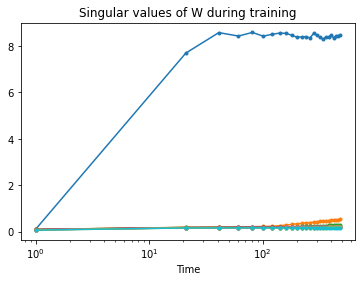

In [3]:
f, alltime = loadTMCsave(MODEL_DIR.joinpath(model_name))

nvalsing = 10 # The number of singular values to plot
S = plot_valsing_evol(f, alltime, nvalsing, scale='logx')

In [4]:
# These are all the model saved times available in the file
print(alltime)

[  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481]


# Potential/Probability Analysis

In [39]:
# Parameters to reconstruct the probability
t = 461 # The time at which we want to compute the probability
nb_chain = 100 # nb of MC chains for each w_hat
it_mcmc = 200 # Nb of it_mcmc for each chain
it_mean = 100 # Nb of iterations to compute the mean
N = 20000 # Constraint
nb_point = 250 # Nb of discretization points for w_hat 
border_length = 0.1
direction = 0

In [41]:
myRBM = loadTMCRBM(f, t, lr=0.1, NGibbs=10, mb_s=500, num_pcd=500, PCA=True, direction=1, device=device, dtype=dtype)

In [42]:
res, p_m, grad_pot, w_hat_b = ComputeProbabilityTMC1D(myRBM, data.T, nb_chain, it_mcmc, it_mean, N, nb_point, border_length, V, device=device)

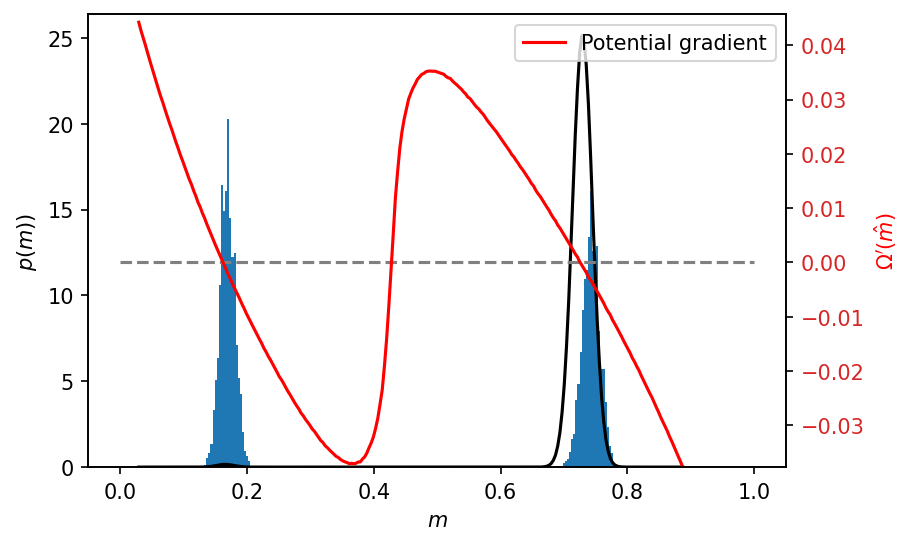

In [43]:
fig, ax1 = plt.subplots(dpi=150)
ax2 = ax1.twinx()
ax1.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200);
ax1.plot(w_hat_b[1:], p_m.cpu().numpy(), color='black')
ax1.set_ylabel(r"$p(m))$", color='black')
ax1.set_xlabel(r"$m$")

color = 'tab:red'
ax2.plot(w_hat_b[1:],grad_pot[1:],color='red', label = "Potential gradient")
ax2.hlines(0,0,1,linestyles='dashed' ,color = 'grey')
ax2.set_ylabel(r"$\Omega'(\hat{m})$", color='red')
ax2.set_ylim([grad_pot.min(), grad_pot.max()])
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlabel(r"$\hat{m}$")

ax2.legend()

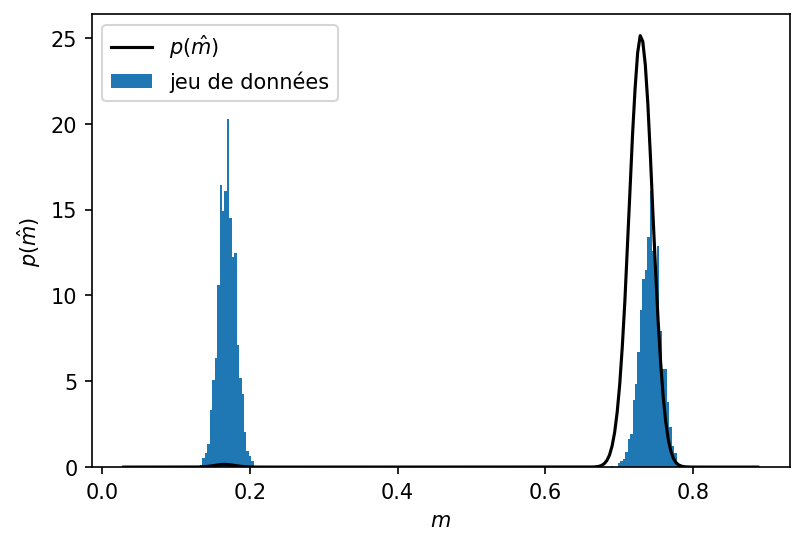

In [44]:
fig, ax = plt.subplots(dpi=150)
ax.hist(proj_data[:,0].numpy(), label = 'jeu de données', density=True, bins=200);
ax.plot(w_hat_b[1:], p_m.cpu().numpy(), color='black', label = r'$p(\hat{m})$')

ax.set_ylabel(r"$p(\hat{m})$", color='black')
ax.set_xlabel(r"$m$")
ax.legend();

# Sampling


In [20]:
n_sample = 2000

In [21]:
new_sample, _ = myRBM.genDataTMC1D(n_sample, V[:,direction], it_mcmc=600)

In [22]:
proj_gen =  torch.mm(new_sample.T, V)/myRBM.Nv**.5

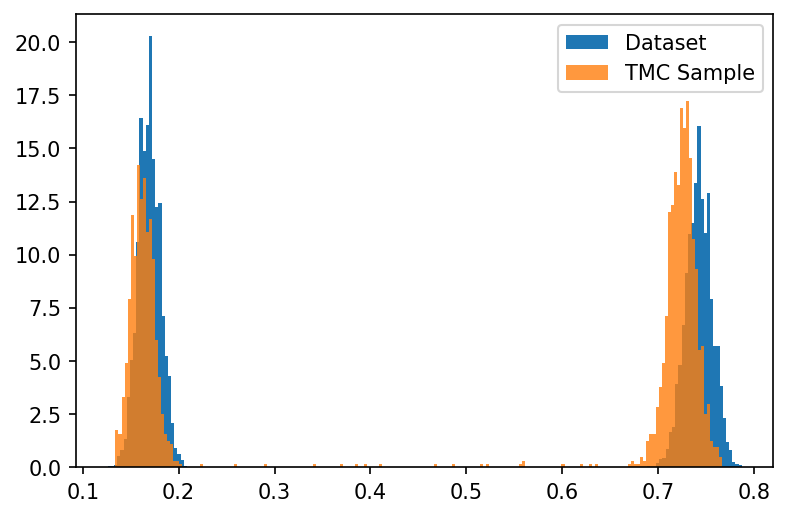

In [23]:
fig, ax = plt.subplots(1,1, dpi=150)
ax.hist(proj_data[:,0].cpu().numpy(), bins=200, density=True, label='Dataset')
ax.hist(proj_gen[:,0].cpu().numpy(), bins=200, density=True, label='TMC Sample', alpha=.8);
ax.legend()